Pruning Filters for Efficient ConvNets, 17'ICLR
===

modified from https://github.com/tyui592/Pruning_filters_for_efficient_convnets

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
device = torch.device('cuda')

from evaluate import test_network
from prune import prune_network
from network import VGG
from train import train_network

### load VGG16 model (pretrained)

In [2]:
load_path = 'trained_models/'

args = torch.load(load_path+'arguments.pth')
for key, value in vars(args).items():
    print("%s: %s"%(key, value))

#################################
args.load_path = load_path + 'check_point.pth'
args.save_path = load_path+'%s/'%time.ctime().replace(' ', '_')
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

gpu_no: 3
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16_bn
start_epoch: 0
epoch: 350
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None


### check: accuracy of test data

In [3]:
network, test_set, (top1, top5) = test_network(args)

Files already downloaded and verified
---> Evalute network
Tue Nov 17 23:04:07 2020: Test information, Data(s): 1.493, Forward(s): 1.002, Top1: 93.730, Top5: 99.330, 


### 1. Normalized absolute sum of the filter weights (Figure 2 (a) of the paper)

In [4]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

Layer weight dimension: [C_out, C_in, k, k]

-> calculate the sum of its absolute kernel weights over input channel dimension
\begin{equation} s_j= \sum_{l=1}^{n_i} \sum |K_l| \end{equation}

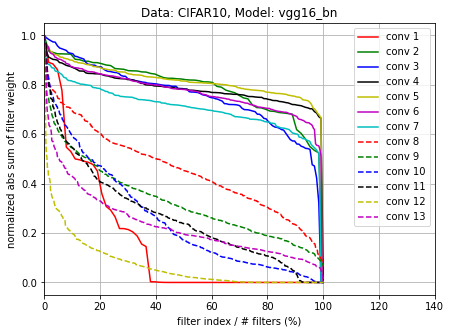

In [5]:
plt.figure(figsize=(7,5))
conv_count = 0
for layer in network.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count%len(colors)] + lines[conv_count//len(colors)]
        
        # filter weight dimension info: out_ch, in_ch, k1, k2
        fw = layer.weight.data.cpu().numpy()
        
        # sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # normalize with maximum value
        normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label='conv %d'%conv_count)
        
plt.title("Data: %s, Model: %s"%(args.data_set, args.vgg))        
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("figure1.png", dpi=150, bbox_inches='tight')
plt.show()        

large slope: 상대적으로 중요한 filter들이 많은 layer -> sensitive to pruning  (conv2~conv7)

flat slope : 덜 중요한 filter들이 많은 layer         -> insensitive to pruning

### 2. Accuracy of the pruned network (Figure 2 (b) of the paper)

Pruning modules

In [6]:
def prune_network(args, network=None):
    device = torch.device("cuda" if args.gpu_no >= 0 else "cpu")

    if network is None:
        network = VGG(args.vgg, args.data_set)
        if args.load_path:
            check_point = torch.load(args.load_path)
            network.load_state_dict(check_point['state_dict'])

    # prune network
    network = prune_step(network, args.prune_layers, args.prune_channels, args.independent_prune_flag)
    network = network.to(device)
    print("---> Prune network")
    #print(network)

    if args.retrain_flag:
        # update arguemtns for retraing pruned network
        args.epoch = args.retrain_epoch
        args.lr = args.retrain_lr
        args.lr_milestone = None # don't decay learning rate

        network = train_network(args, network)

    return network

def prune_step(network, prune_layers, prune_channels, independent_prune_flag):
    network = network.cpu()

    count = 0 # count for indexing 'prune_channels'
    conv_count = 1 # conv count for 'indexing_prune_layers'
    dim = 0 # 0: prune corresponding dim of filter weight [out_ch, in_ch, k1, k2]
    residue = None # residue is need to prune by 'independent strategy'
    for i in range(len(network.features)):
        if isinstance(network.features[i], torch.nn.Conv2d):
            if dim == 1:
                new_, residue = get_new_conv(network.features[i], dim, channel_index, independent_prune_flag)
                network.features[i] = new_
                dim ^= 1

            if 'conv%d'%conv_count in prune_layers:
                '''
                get_channel_index: get channel index by sorting the sum of kernel weights
                get_new_conv: create a new conv layer without indexed filters
                '''
                channel_index = get_channel_index(network.features[i].weight.data, prune_channels[count], residue)
                new_ = get_new_conv(network.features[i], dim, channel_index, independent_prune_flag)
                network.features[i] = new_
                dim ^= 1
                count += 1
            else:
                residue = None
            conv_count += 1

        elif dim == 1 and isinstance(network.features[i], torch.nn.BatchNorm2d):
            new_ = get_new_norm(network.features[i], channel_index)
            network.features[i] = new_

    # update to check last conv layer pruned
    if 'conv13' in prune_layers:
        network.classifier[0] = get_new_linear(network.classifier[0], channel_index)

    return network

def get_channel_index(kernel, num_elimination, residue=None):
    # get cadidate channel index for pruning
    ## 'residue' is needed for pruning by 'independent strategy'

    sum_of_kernel = torch.sum(torch.abs(kernel.view(kernel.size(0), -1)), dim=1)
    if residue is not None:
        sum_of_kernel += torch.sum(torch.abs(residue.view(residue.size(0), -1)), dim=1)
    
    vals, args = torch.sort(sum_of_kernel)

    return args[:num_elimination].tolist()

def index_remove(tensor, dim, index, removed=False):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    size_ = list(tensor.size())
    new_size = tensor.size(dim) - len(index)
    size_[dim] = new_size
    new_size = size_

    ### remove indexed filters ###
    select_index = list(set(range(tensor.size(dim))) - set(index))
    new_tensor = torch.index_select(tensor, dim, torch.tensor(select_index))
    
    if removed:
        return new_tensor, torch.index_select(tensor, dim, torch.tensor(index))

    return new_tensor

def get_new_conv(conv, dim, channel_index, independent_prune_flag=False):
    ### remove a column in kernel matrix ###
    if dim == 0:
        new_conv = torch.nn.Conv2d(in_channels=conv.in_channels,
                                   out_channels=int(conv.out_channels - len(channel_index)),
                                   kernel_size=conv.kernel_size,
                                   stride=conv.stride, padding=conv.padding, dilation=conv.dilation)
        
        new_conv.weight.data = index_remove(conv.weight.data, dim, channel_index)
        new_conv.bias.data = index_remove(conv.bias.data, dim, channel_index)

        return new_conv

    ### remove a row in kernel matrix (related kernel in the next layer) ###
    elif dim == 1:
        new_conv = torch.nn.Conv2d(in_channels=int(conv.in_channels - len(channel_index)),
                                   out_channels=conv.out_channels,
                                   kernel_size=conv.kernel_size,
                                   stride=conv.stride, padding=conv.padding, dilation=conv.dilation)
        
        new_weight = index_remove(conv.weight.data, dim, channel_index, independent_prune_flag)
        residue = None
        if independent_prune_flag:
            new_weight, residue = new_weight
        new_conv.weight.data = new_weight
        new_conv.bias.data = conv.bias.data

        return new_conv, residue

def get_new_norm(norm, channel_index):
    new_norm = torch.nn.BatchNorm2d(num_features=int(norm.num_features - len(channel_index)),
                                    eps=norm.eps,
                                    momentum=norm.momentum,
                                    affine=norm.affine,
                                    track_running_stats=norm.track_running_stats)

    new_norm.weight.data = index_remove(norm.weight.data, 0, channel_index)
    new_norm.bias.data = index_remove(norm.bias.data, 0, channel_index)

    if norm.track_running_stats:
        new_norm.running_mean.data = index_remove(norm.running_mean.data, 0, channel_index)
        new_norm.running_var.data = index_remove(norm.running_var.data, 0, channel_index)
        
    return new_norm

def get_new_linear(linear, channel_index):
    new_linear = torch.nn.Linear(in_features=int(linear.in_features - len(channel_index)),
                                out_features=linear.out_features,
                                bias=linear.bias is not None)
    new_linear.weight.data = index_remove(linear.weight.data, 1, channel_index)
    new_linear.bias.data = linear.bias.data
    
    return new_linear

In [7]:
prune_step_ratio = 1/8
max_channel_ratio = 0.90 

prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']

In [8]:
top1_accuracies = {}
top5_accuracies = {}

for conv, channel in zip(prune_layers, prune_channels):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)
        print("========"*10)

---> Evalute network
Tue Nov 17 23:04:16 2020: Test information, Data(s): 1.483, Forward(s): 0.552, Top1: 93.730, Top5: 99.330, 

Tue Nov 17 23:04:16 2020: conv1 Layer, 8 Channels pruned
---> Prune network
---> Evalute network
Tue Nov 17 23:04:19 2020: Test information, Data(s): 1.460, Forward(s): 0.532, Top1: 93.730, Top5: 99.330, 

Tue Nov 17 23:04:19 2020: conv1 Layer, 16 Channels pruned
---> Prune network
---> Evalute network
Tue Nov 17 23:04:21 2020: Test information, Data(s): 1.468, Forward(s): 0.543, Top1: 93.730, Top5: 99.330, 

Tue Nov 17 23:04:21 2020: conv1 Layer, 24 Channels pruned
---> Prune network
---> Evalute network
Tue Nov 17 23:04:24 2020: Test information, Data(s): 1.482, Forward(s): 0.537, Top1: 93.730, Top5: 99.330, 

Tue Nov 17 23:04:24 2020: conv1 Layer, 32 Channels pruned
---> Prune network
---> Evalute network
Tue Nov 17 23:04:27 2020: Test information, Data(s): 1.471, Forward(s): 0.540, Top1: 93.730, Top5: 99.330, 

Tue Nov 17 23:04:27 2020: conv1 Layer, 40 C

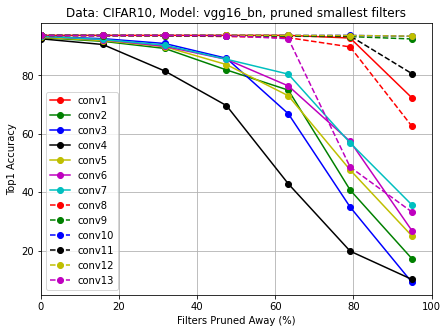

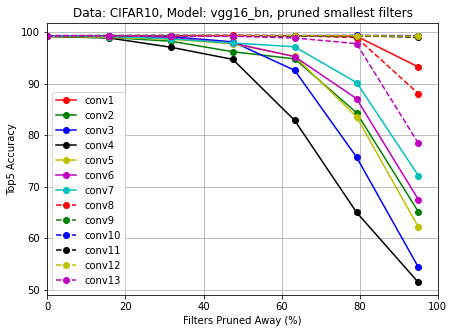

In [9]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top5.png", dpi=150, bbox_inches='tight')
plt.show()                

### 3. Accuracy of the retrained pruned network (Figure 2 (c) of the paper)

In [10]:
args.retrain_flag = True
args.retrain_epoch = 10
args.independent_prune_flag = False
args.retrain_lr = 0.001
prune_step_ratio = 1/4
max_channel_ratio = 0.50    # originally 0.90

In [11]:
top1_accuracies = {}
top5_accuracies = {}

# Prune and retrain iteratively
for conv, channel in zip(prune_layers, prune_channels):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)
        print("========"*10)

---> Evalute network
Tue Nov 17 23:10:12 2020: Test information, Data(s): 1.472, Forward(s): 0.530, Top1: 93.730, Top5: 99.330, 

Tue Nov 17 23:10:12 2020: conv1 Layer, 10 Channels pruned
---> Prune network
Files already downloaded and verified
--> Train network
Tue Nov 17 23:10:14 2020: Epoch [0], Iteration [0/391/], Data(s): 0.035, Loss(s): 0.002, Forward(s): 0.216, Backward(s): 0.318, Top1: 100.000, Top5: 100.0000, Loss: 0.003
Tue Nov 17 23:10:20 2020: Epoch [0], Iteration [100/391/], Data(s): 0.037, Loss(s): 0.004, Forward(s): 0.005, Backward(s): 0.016, Top1: 99.869, Top5: 100.0000, Loss: 0.007
Tue Nov 17 23:10:26 2020: Epoch [0], Iteration [200/391/], Data(s): 0.037, Loss(s): 0.003, Forward(s): 0.004, Backward(s): 0.014, Top1: 99.845, Top5: 100.0000, Loss: 0.008
Tue Nov 17 23:10:32 2020: Epoch [0], Iteration [300/391/], Data(s): 0.037, Loss(s): 0.004, Forward(s): 0.004, Backward(s): 0.013, Top1: 99.844, Top5: 100.0000, Loss: 0.008
Tue Nov 17 23:10:38 2020: Epoch [1], Iteration [0/

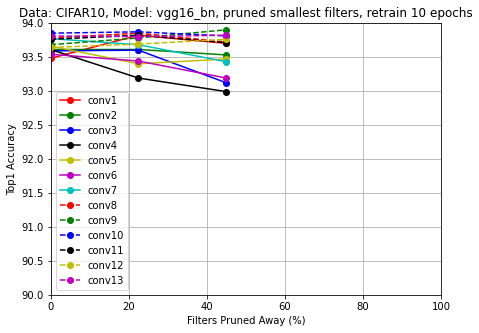

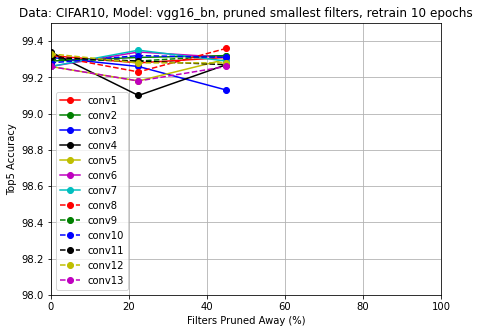

In [16]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 45, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.ylim(90, 94)
plt.savefig("figure3_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 45, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.ylim(98, 99.5)
plt.savefig("figure3_top5.png", dpi=150, bbox_inches='tight')
plt.show()                